<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/tf_keypoint_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/gibsonx/tf_skeleton.git

fatal: destination path 'tf_skeleton' already exists and is not an empty directory.


In [3]:
!pip install -r /content/tf_skeleton/requirements.txt > /dev/null

In [4]:
from pycocotools.coco import COCO
import numpy as np
import os.path
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, json, cv2, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

from keras.models import Sequential

from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    BatchNormalization,
    MaxPool2D,
)

In [5]:
img_dir="/content/drive/MyDrive/Dataset/aspine202030604/images"
annotations_file="/content/drive/MyDrive/Dataset/aspine202030604/annotations/person_keypoints_Train.json"

In [6]:
coco=COCO(annotations_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
#validation set details
imgIds = coco.getImgIds()
print("Total images: {}".format(len(imgIds)))
rand=np.random.randint(0,len(imgIds))
img = coco.loadImgs(imgIds[rand])[0]
print("Image example:")
print(img)
annIds=coco.getAnnIds()
print("\nTotal annotations: {}".format(len(annIds)))
ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
print("Annotation example:")
print(ann)

Total images: 188
Image example:
{'id': 172, 'width': 1184, 'height': 2112, 'file_name': 'img-00152-00001.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}

Total annotations: 188
Annotation example:
[{'id': 158, 'image_id': 172, 'category_id': 1, 'segmentation': [], 'area': 373730.9545, 'bbox': [199.26, 1537.56, 773.69, 483.05], 'iscrowd': 0, 'attributes': {'occluded': False}, 'keypoints': [392.17, 1539.0, 2, 774.71, 1537.56, 2, 199.26, 1659.28, 2, 972.95, 1662.1, 2, 496.01, 1680.81, 2, 691.73, 1685.74, 2, 434.74, 1632.26, 2, 756.57, 1644.13, 2, 598.68, 1693.06, 2, 342.51, 1877.54, 2, 849.66, 1880.64, 2, 385.44, 2020.61, 2, 809.06, 2018.97, 2, 530.64, 1560.28, 2, 660.97, 1558.64, 2, 594.0, 1601.31, 2], 'num_keypoints': 16}]


In [8]:
keypoints_classes_ids2names = {0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: '11', 11: '12', 12: '13', 13: '14', 14: '15', 15: '16'}

def visualize(p, keypoints):

    image = mpimg.imread(p)

    # for kps in keypoints:
    for idx, kp in enumerate(keypoints):
        image = cv2.putText(image.copy(), "" + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 2, (32,253,0), 3, cv2.LINE_AA)
        image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)

        # for kps in keypoints:
        #     for idx, kp in enumerate(kps):
        #         image = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
        #         image = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    plt.figure(figsize=(25,25))
    plt.imshow(image)
    plt.show()


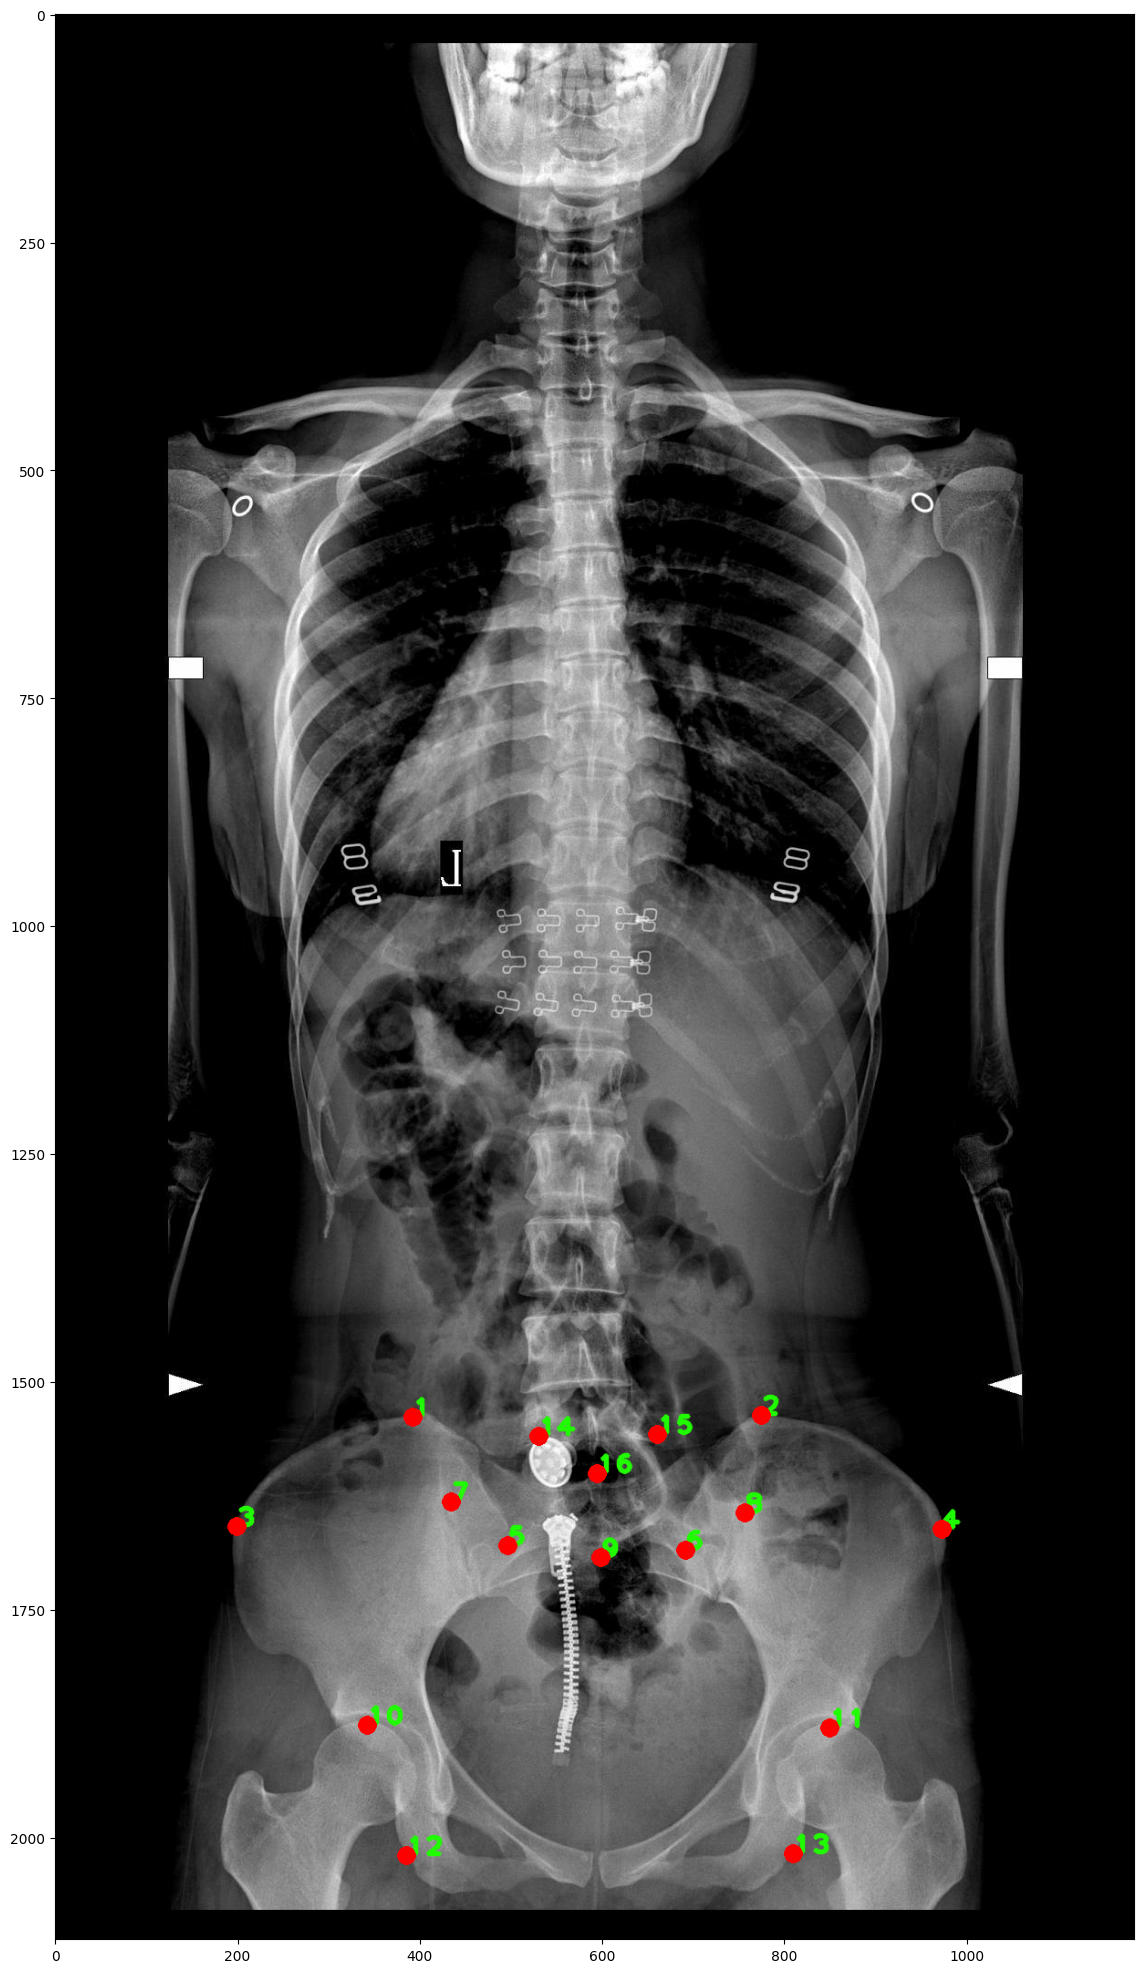

In [9]:
keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]

def CoupeToInt(coupe: List[float]) -> List[int]:
    return list(map(int, coupe))

converted_keypoints = [ CoupeToInt(el[0:2]) for kp in keypoints_original for el in kp ]

imgPath = os.path.join(img_dir,img['file_name'])
visualize(imgPath,converted_keypoints)

In [10]:
kps_metrix = []
image_list = []

for id in imgIds:
    img = coco.loadImgs(id)[0]
    imgPath = os.path.join(img_dir,img['file_name'])
    image_list.append(Image.open(imgPath))

    # load annotations
    ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
    keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]
    kps_row = []
    for kp in keypoints_original:
        for el in kp:
            kps_row.extend(el[0:2])

    kps_metrix.append(kps_row)

df = pd.DataFrame(kps_metrix)

image_array_list = [np.array(img) for img in image_list]
df['image'] = image_array_list


In [11]:
# df.to_csv('/content/drive/MyDrive/Dataset/df.csv')

In [12]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(include_top=False, input_shape=(2112,1184,3), pooling='avg')

#(2140, 30)
from keras.models import Sequential
from keras.layers import Dense, Flatten,BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers

top_model = Sequential([
    Dense(512, activation='relu', input_shape=(2048,),kernel_initializer='he_normal'),
    Dense(256, activation='relu',kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(96, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(48, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dense(32)
])
top_model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])

final_model = Sequential([base_model, top_model])
final_model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 sequential (Sequential)     (None, 32)                1231920   
                                                                 
Total params: 24819632 (94.68 MB)
Trainable params: 24766512 (94.48 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [13]:
# Building a CNN model using Sequential API
# model = Sequential([
#     Conv2D(64, (5, 5), padding='same', use_bias=False, input_shape=(2112, 1184, 3)),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(2, 2)),

#     Conv2D(64, (5, 5), padding='same', use_bias=False),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(2, 2)),

#     Conv2D(128, (4, 4), padding='same', use_bias=False),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(2, 2)),

#     Conv2D(128, (4, 4), padding='same', use_bias=False),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(2, 2)),

#     Conv2D(256, (3, 3), padding='same', use_bias=False),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(2, 2)),

#     Conv2D(512, (2, 2), padding='same', use_bias=False),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(2, 2)),

#     Flatten(),
#     Dense(1024, activation='relu'),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(32)
# ])

In [14]:
# model.summary()

NameError: ignored

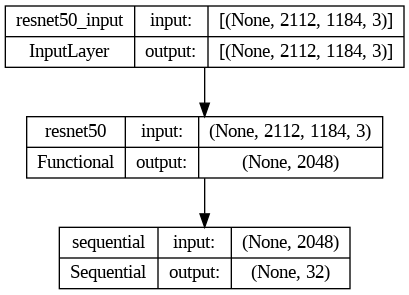

In [15]:
tf.keras.utils.plot_model(final_model, show_shapes=True)

In [16]:
# initializing few hyper parameters
epochs = 100
batch_size = 8
validation_split = 0.2

In [17]:
y_train=df.loc[:, df.columns != 'image']
y_train.shape

(188, 32)

In [18]:
x_train=np.stack(df['image'])

In [19]:
final_model.compile(optimizer='Adam',loss='mean_squared_error',metrics=['accuracy'])
history=final_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = validation_split)

Epoch 1/100
19/19 [==============================] - 87s 2s/step - loss: 1423052.7500 - accuracy: 0.0000e+00 - val_loss: 18865868.0000 - val_accuracy: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 11s 566ms/step - loss: 972344.6250 - accuracy: 0.0000e+00 - val_loss: 50547453952.0000 - val_accuracy: 0.0000e+00
Epoch 3/100
19/19 [==============================] - 11s 565ms/step - loss: 536107.8750 - accuracy: 0.0267 - val_loss: 110841720.0000 - val_accuracy: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 11s 565ms/step - loss: 420351.6875 - accuracy: 0.1133 - val_loss: 15555556352.0000 - val_accuracy: 0.5000
Epoch 5/100
19/19 [==============================] - 11s 564ms/step - loss: 293341.6562 - accuracy: 0.2000 - val_loss: 2573752320.0000 - val_accuracy: 0.5000
Epoch 6/100
19/19 [==============================] - 11s 564ms/step - loss: 342097.2188 - accuracy: 0.2200 - val_loss: 202294576.0000 - val_accuracy: 0.5000
Epoch 7/100
19/19 [=================

KeyboardInterrupt: ignored

In [ ]:
final_model.save_weights('/content/drive/MyDrive/Dataset/skeleton_keypoint_weights.h5')

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train Dataset')
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='validatoin_loss')
plt.legend()
plt.subplot(1,2,2)
plt.title('Validation Dataset')
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.legend()
plt.show()